# Taiwan Clients - Decision Tree Investigation

Objective: Create a binary classifier that, given a set of features, decides whether the customer will default (1) or not (0) on the credit payment.

[Dataset Page](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

## Feature Set

- X1 (LIMIT_BAL): Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2 (SEX): Gender (1 = male; 2 = female).
- X3 (EDUCATION): Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4 (MARRIAGE): Marital status (1 = married; 2 = single; 3 = others).
- X5 (AGE): Age (year).
- X6 - X11 (PAY_0 - PAY_6): History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 (PAY_0) = the repayment status in September, 2005; X11 (PAY_6) = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17 (BILL_AMT1 - BILL_AMT6): Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23 (PAY_AMT1 - PAY_AMT6): Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.





In [1]:
!pip install xlrd>=2.0.1


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Class for Loading the DataFrame  

In [2]:
import requests
import zipfile
import io
import os
import pandas as pd
import numpy as np
import uuid 

class DataFrameLoader:
  TAIWAN_CLIENTS_URL = "https://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip"
  TAIWAN_CLIENTS_BASE_PATH = "/tmp/content/taiwan-clients/"

  def _download_taiwan_clients(self, path):
    os.makedirs(path, exist_ok=True)
    df_path = os.path.join(DataFrameLoader.TAIWAN_CLIENTS_BASE_PATH, str(uuid.uuid4()))
    with requests.get(self.TAIWAN_CLIENTS_URL) as response:
      z = zipfile.ZipFile(io.BytesIO(response.content))
      z.extractall(df_path)
      z.close()

    downloaded_file = os.listdir(df_path).pop()
    
    file_path = os.path.join(df_path, "df.xls")
    os.rename(os.path.join(df_path, downloaded_file), file_path)

    return file_path

  def taiwan_clients(self, download_path=TAIWAN_CLIENTS_BASE_PATH):
    df_path = self._download_taiwan_clients(path=download_path)
    return pd.read_excel(df_path, skiprows=1)




## Initially Loading all Features, except `ID`

In [3]:
df = DataFrameLoader().taiwan_clients()

df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [4]:
x_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

y_cols = ['default payment next month']
X, y = df.loc[:, x_cols], df.loc[:, y_cols]

## Splitting dataset and creating the training pipeline

The training pipeline will have the following steps
1. Scaling: Using Standard Scaler, will fit the scaler with the training data and also transform this data to scaled values
2. Oversampling: Using SMOTE, will oversample the dataset to have the same number of classes in both cases (this dataset over-represents the non defaulted clients that represents ~78.8% of the data)
3. Model training: Using the DecisionTreeClassifier, will fit the train data



In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE


X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    random_state=42)


def fit_train(X_train, y_train, scaler: StandardScaler, smote: SMOTE, model):

  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  if smote is not None:
    X_train, y_train = smote.fit_resample(X_train, y_train)
  model.fit(X_train, y_train)

  return {
      "scaler": scaler,
      "smote": smote,
      "model": model
  }

# Functions to run the test data, SMOTE won't be necessary for it
def preprocess(operators, X, y):
  X = operators["scaler"].transform(X)
  return X, y

def predict(operators, X_test, y_test):
  X_test = operators["scaler"].transform(X_test)
  return operators["model"].predict(X_test)

## Additional functions to read into the model output and validation



In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
def calculate_confusion_matrix(operators, X, y):
  y_pred = predict(operators, X_test, y_test)
  cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
  return cm

def plot_confusion_matrix(cm):
  display = ConfusionMatrixDisplay(confusion_matrix=cm)
  display.plot()
  return display

def plot_roc_curve(operators, X, y, **kwargs):
  processed_X, processed_Y = preprocess(operators, X, y)
  display = RocCurveDisplay.from_estimator(estimator=operators["model"], X=processed_X, y=processed_Y, **kwargs)

  return display

def process_metrics(operators, X, y):
  cm = calculate_confusion_matrix(operators, X, y)
  plot_confusion_matrix(cm)
  plt.show()
  plot_roc_curve(operators, X, y)
  plt.show()

def choose_best_operator_based_on(operators, metric):

  metric_value = -1
  best_operator_index = 0
  for i, operator in enumerate(operators):
    y_pred = predict(operator, X_test, y_test)
    precision, recall, fscore, support = score(y_test, y_pred, average="macro")
    metrics = {
        "precision": precision,
        "recall": recall,
        "fscore": fscore,
        "support": support
    }
    if metrics[metric] > metric_value:
      metric_value = metrics[metric]
      best_operator_index = i
  return best_operator_index, operators[best_operator_index]

In [7]:
operators = [fit_train(
  X_train=X_train,
  y_train=y_train,
  scaler = StandardScaler(),
  smote = SMOTE(random_state=42),
  model = DecisionTreeClassifier(random_state=42, max_depth=depth)
) for depth in (2, 5, 10, 20, None)]


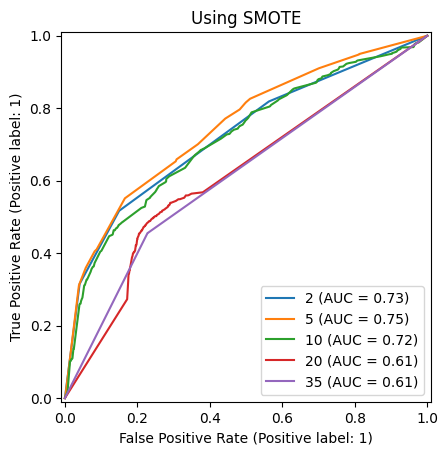

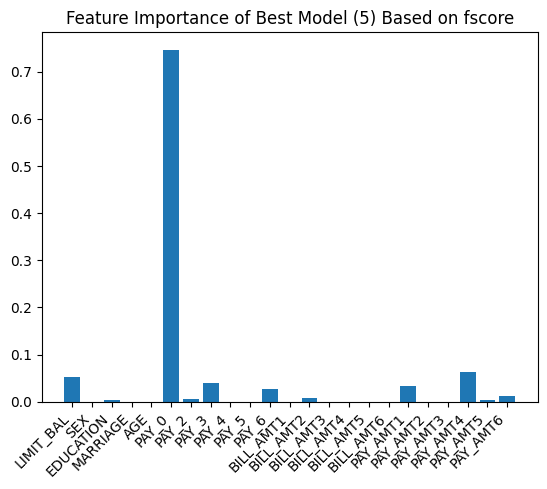

In [8]:
from sklearn.metrics import precision_recall_fscore_support as score
ax = plt.gca()
plt.title("Using SMOTE")
for operator in operators:
  plot_roc_curve(operator, X_test, y_test, ax=ax, name = str(operator["model"].tree_.max_depth))

plt.show()

metric = "fscore"
_, best_operator = choose_best_operator_based_on(operators, metric)

plt.title("Feature Importance of Best Model ({}) Based on {}".format(
    best_operator["model"].tree_.max_depth, metric)
)
plt.bar(x_cols, best_operator["model"].feature_importances_)
plt.xticks(rotation=45, ha="right")
plt.show()

In [9]:
y_pred = predict(best_operator, X_test, y_test)

precision, recall, fscore, support = score(y_test, y_pred)

for label, string in enumerate(["non defaulted", "defaulted"]):
  print("{}: Precision {:.3f} - Recall {:.3f} - F1 {:.3f}".format(string, precision[label], recall[label], fscore[label]))

precision, recall, fscore, support = score(y_test, y_pred, average="macro")

print("All: Precision {:.3f} - Recall {:.3f} - F1 {:.3f}".format(precision, recall, fscore))

non defaulted: Precision 0.870 - Recall 0.834 - F1 0.852
defaulted: Precision 0.480 - Recall 0.551 - F1 0.513
All: Precision 0.675 - Recall 0.693 - F1 0.683
